# Integer knapsack problem solved with Gurobi optimizer
This notebook solves the integer knapsack problem:

\begin{alignat}{3} \tag{1}
\textrm{max}	&& \sum_{i \in I}{c_i x_i} 	& 			&  \\
\textrm{s.t.} 	&& \sum_{i \in I}{a_i x_i} 	& \leq B 	& \\
				&& x_i						& \leq 3x_j & \quad \forall i \in I, \forall j \in I  \\
				&& x_i 						& \geq 0 	& \quad \forall i \in I 
\end{alignat}

using Gurobi optimizer with its Python API.

In [1]:
# Optimization Project: Biscuit Optimizer
# Roberto Basla
# Politecnico di Milano
# A.Y. 2021/2022

import os
import numpy as np
from pprint import pprint

import gurobipy as gp
from gurobipy import GRB

import sys
sys.path.append("..")
from utils import utils

## Inputs

In [2]:
images_dir = "C:/Users/rober/OneDrive - Politecnico di Milano/Documenti/Courses/Optimization/Project/report/img/"

In [3]:
image_path = os.path.join(images_dir, "input_image/input_image.jpg")
bitmask_path = os.path.join(images_dir, "input_image/mask_1.png")

base_image, bitmask = utils.load_base_image(image_path, bitmask_path)

Subsampled shape: (134, 125)


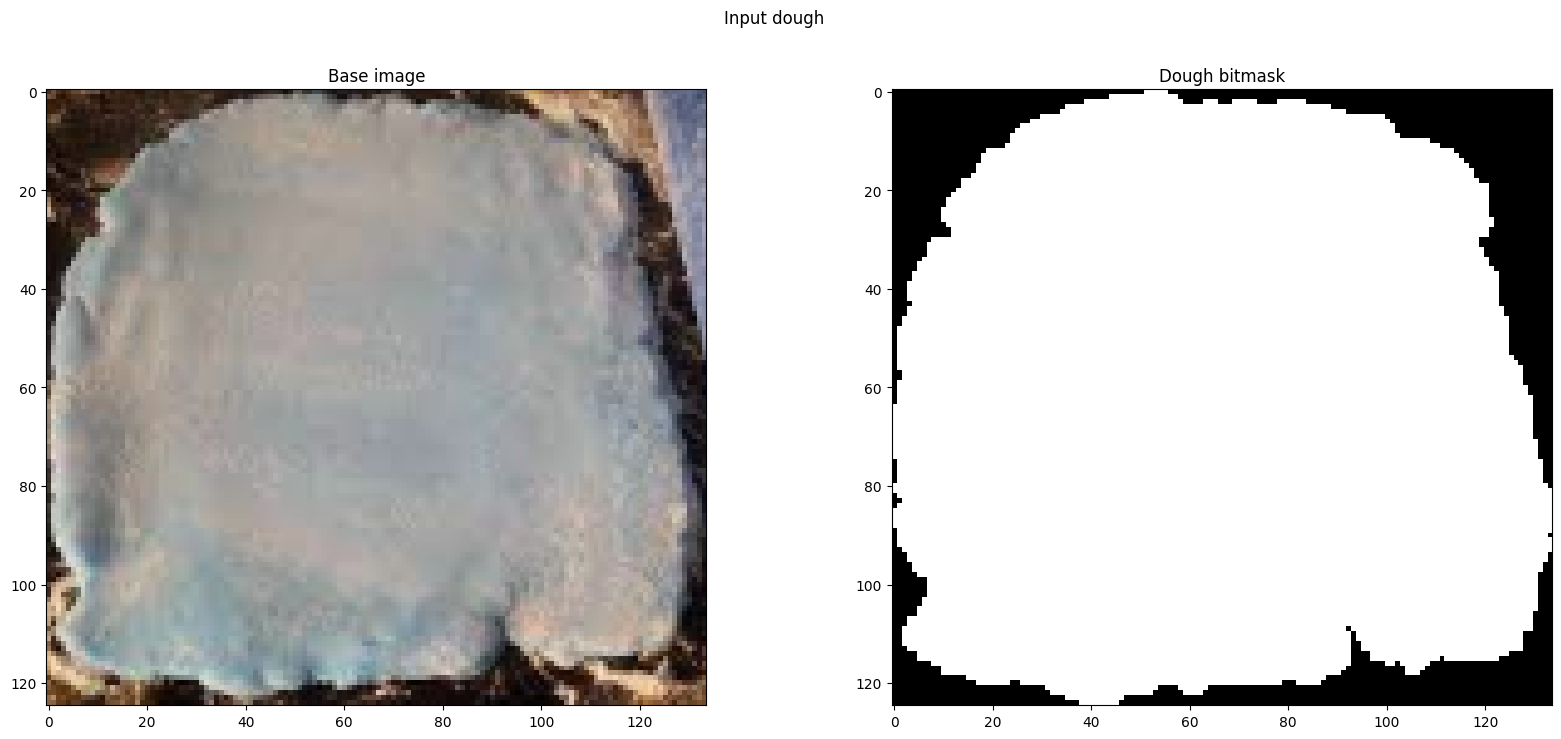

In [4]:
base_image, bitmask = utils.subsample_base_image(base_image, bitmask, resize_factor=0.7, display=True)

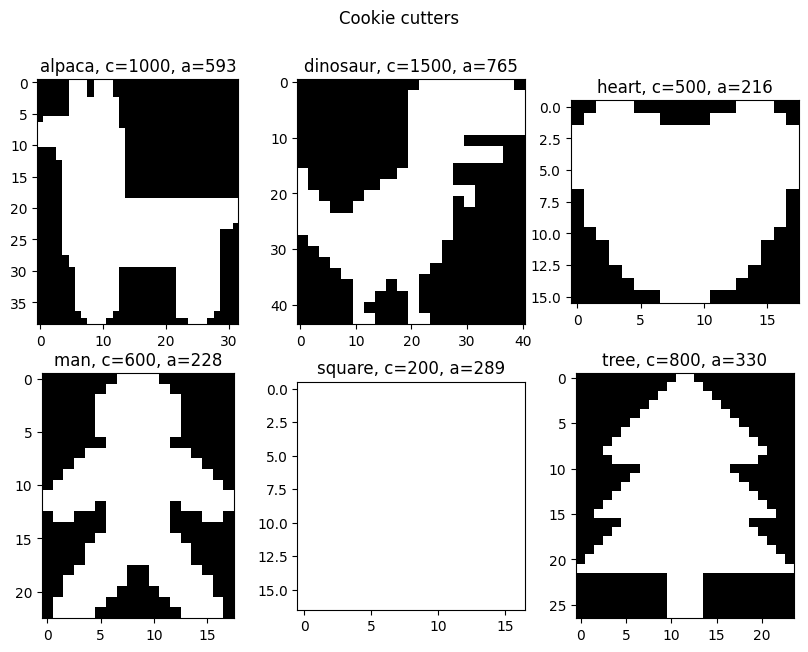

In [5]:
cutters = utils.load_cutters(cutters_path=os.path.join(images_dir, "cutters"), display=True)

## Model

Model definition

In [6]:
model = gp.Model("biscuit_optimizer")

SETS

The only set is the one of available cutters.

In [7]:
I = list(range(len(cutters)))
print(f"I = {I}")

I = [0, 1, 2, 3, 4, 5]


PARAMETERS

The knapsack budget $B$ is the number of all pixels different from 0 in the mask, while $c_i$s correspond to the cutter values and $a_i$s to their areas (respectively, the costs and weights in the knapsack formulation).

In [8]:
B = np.count_nonzero(bitmask)
c = [cutter['value'] for cutter in cutters]
a = [cutter['area'] for cutter in cutters]

print(f"B = {B}")
print(f"c = {c}")
print(f"a = {a}")

B = 13929
c = [1000, 1500, 500, 600, 200, 800]
a = [593, 765, 216, 228, 289, 330]


VARIABLES

The model's variables consist in a vector of integer values $\underline{x}$, where each entry corresponds to the number of times the cookie cutter is selected.

In [9]:
x = model.addVars(I, lb=0, ub=B, vtype=GRB.INTEGER, name="x")

OBJECTIVE FUNCTION

The objective consists in maximizing the sum of the variables times their values.

In [10]:
model.setObjective(sum([x[i] * c[i] for i in I]), GRB.MAXIMIZE)

CONSTRAINTS

The first constraint is the budget.

In [11]:
model.addConstr(sum([x[i] * a[i] for i in I]) <= B, name="budget")

<gurobi.Constr *Awaiting Model Update*>

The other constraints are the ones related to the cutter frequency.

In [12]:
number_constraints = model.addConstrs((x[i] <= 3 * x[j] for i in I for j in I), name="number")

## Model solution

In [13]:
model.optimize()
x_solution = [var.X for i, var in x.items()]
solution = {i: var.X for i, var in x.items()}
used_dough = sum([var.X * a[i] for i, var in x.items()])
print()
print("x =", x_solution)
print(f"Objective value: {model.ObjVal}")

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 37 rows, 6 columns and 72 nonzeros
Model fingerprint: 0x49d79364
Variable types: 0 continuous, 6 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  Objective range  [2e+02, 2e+03]
  Bounds range     [1e+04, 1e+04]
  RHS range        [1e+04, 1e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 6 rows and 0 columns
Presolve time: 0.02s
Presolved: 31 rows, 6 columns, 66 nonzeros
Variable types: 0 continuous, 6 integer (0 binary)

Root relaxation: objective 2.947937e+04, 7 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 29479.3651    0    6   -0.00000 29479.3651      -     -    0s
H    0     0                    29000.000000 29479.3651  

## Solution visualization

In [17]:
print("Solution:")
pprint(solution)

Solution:
{0: 4.0, 1: 4.0, 2: 4.0, 3: 11.0, 4: 4.0, 5: 12.0}


In [15]:
print(f'Cookie dough used = {used_dough} ({round(used_dough / B * 100, 2)}%)')

Cookie dough used = 13920.0 (99.94%)


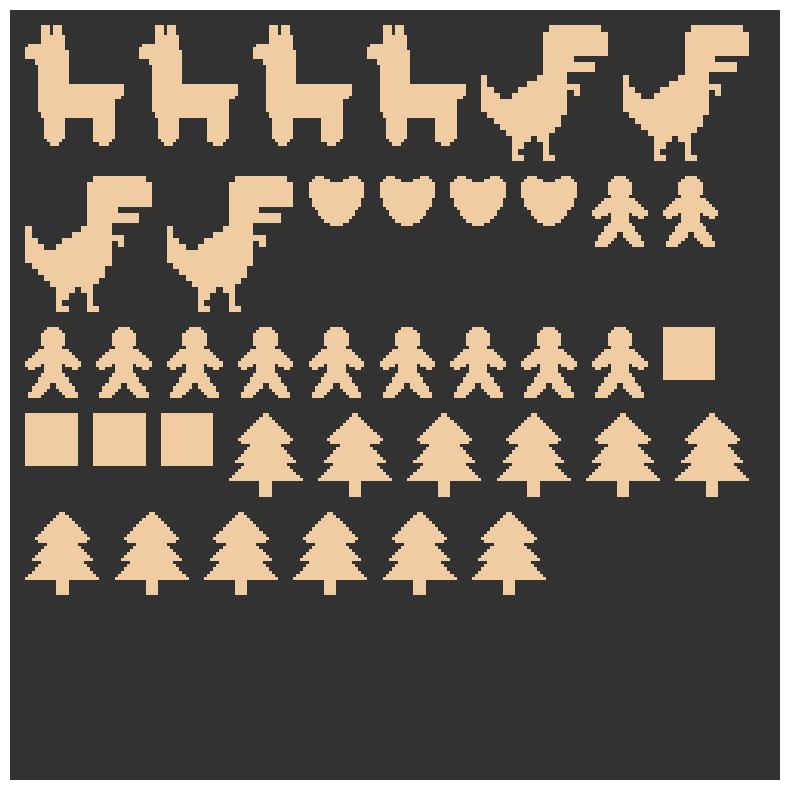

In [16]:
utils.show_pan({i: cutter["mask"] for i, cutter in enumerate(cutters)}, solution)